<a href="https://colab.research.google.com/github/CatMahm/Csolkovits_HW2_CSC302_Group5/blob/main/FINAL_CSC302_GROUP5_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
!pip install joypy
import joypy as jp
from sklearn.linear_model import LinearRegression
from collections import Counter
import rpy2.robjects as robjects

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


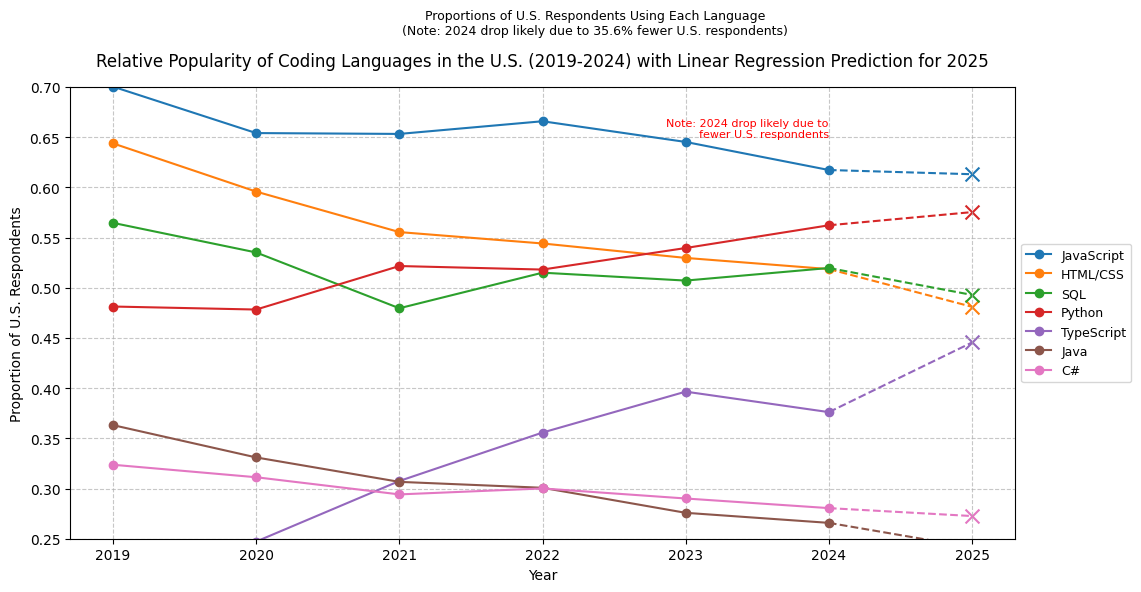

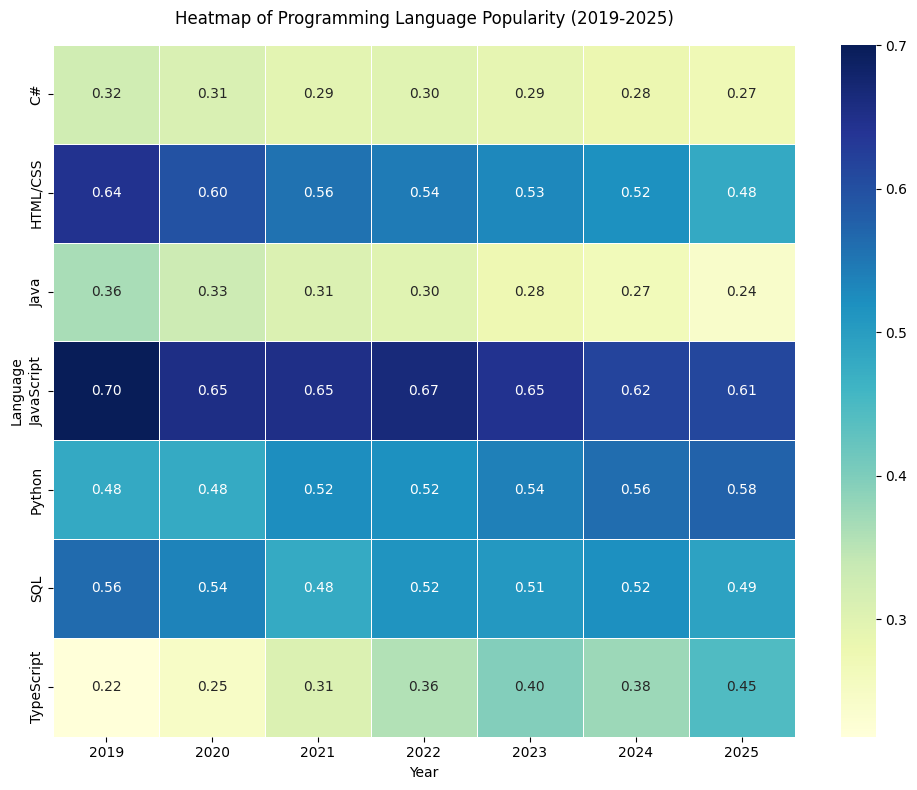

In [ ]:
 #Plot 1: Popularity Over Time (Line Plot) – Ari’s Task (with normalization)
# Purpose: Create a line plot showing the popularity of the top 5 programming languages in the U.S. from 2019-2024.
# Use linear regressions to store predictions in a dictionary
# Notes: Uses 'LanguageHaveWorkedWith' column from Stack Overflow survey data to measure popularity.
#        Popularity is defined as the count of developers who reported using each language per year.
#        Plots the top languages as individual lines over time, with years on the x-axis and developer counts on the y-axis.
#        Uses a line plot with markers for clarity, and a distinct color for each language (default Matplotlib colors).
#        Requires: pandas for data manipulation, matplotlib for plotting. sklearn for linear regression.
# Important Context: The 2024 data shows a significant drop in counts for all languages, likely due to a 35.6% decrease in U.S. respondents
#                    (from ~19,089 in 2023 to ~12,285 in 2024), rather than a genuine decline in popularity.
#                    To address this, the plot now shows normalized counts (proportion of respondents using each language)
#                    to better reflect relative popularity trends, and includes a note about the 2024 drop.

# Ensure Matplotlib displays plots inline in Google Colab
%matplotlib inline

# Define range of years to analyze (2015 to 2024, inclusive)
# Used to load survey data files for each year
years = range(2019, 2025)  # Creates range object: [2019,2020, 2021, 2022, 2023, 2024]

# Initialize empty list to store DataFrames for each year
dfs = []

# Load Stack Overflow survey data for each year (2020-2024) and combine into a single DataFrame
# Loop through each year, load the corresponding CSV file, add a 'Year' column, and append to the list
for year in years:
    # Read CSV file for current year from Google Drive
    # File path assumes files are named like "2020_survey_results_public.csv" in the specified directory
    df_year = pd.read_csv(f"/content/drive/MyDrive/{year}_survey_results_public.csv")
    # Add a 'Year' column to the DataFrame with the current year value (e.g., 2020)
    df_year["Year"] = year
    # Append the DataFrame to the list of DataFrames
    dfs.append(df_year)

# Merge all yearly DataFrames into a single DataFrame
# pd.concat combines list of DataFrames vertically (stacking them)
# ignore_index=True resets index of resulting DataFrame to a new, continuous range (0 to total_rows-1)
# This prevents duplicate indices, which would occur because each yearly DataFrame has its own index starting from 0
# Duplicate indices could cause ambiguity in later operations (e.g., accessing rows with df.loc[0] would return multiple rows)
df = pd.concat(dfs, ignore_index=True)

# Filter the merged DataFrame to include only respondents from the United States
# Uses boolean indexing to select rows where the 'Country' column is "United States of America"
# .copy() creates a deep copy to avoid SettingWithCopyWarning when modifying the filtered DataFrame
us_df = df[df["Country"] == "United States of America"].copy()

# Calculate number of U.S. respondents per year for normalization
# Group by 'Year' and count the number of unique respondents (rows) per year
# This will be used to normalize the language counts to account for changes in survey participation
us_respondents_per_year = us_df.groupby("Year").size()
# print("Number of U.S. respondents per year:\n", us_respondents_per_year)

# Handle missing values in 'LanguageHaveWorkedWith' column
# Fills any NaN values with string "Unknown" to avoid errors during processing
# .loc is used for explicit indexing to modify the column safely
us_df.loc[:, "LanguageHaveWorkedWith"] = us_df["LanguageHaveWorkedWith"].fillna("Unknown")

# Explode the 'LanguageHaveWorkedWith' column into separate rows for each language
# The column contains semicolon-separated strings (e.g., "Python;Java;SQL")
# Split strings into lists using str.split(";")
# Use explode() to create a new row for each language in the list
us_df_exploded = us_df.assign(Language=us_df["LanguageHaveWorkedWith"].str.split(";")).explode("Language")

# Get top 7 languages by overall usage across all years
# value_counts() counts the occurrences of each language in the 'Language' column
# This gives the total number of developers who used each language across all years
language_counts = us_df_exploded["Language"].value_counts()
# Select the top 7 languages by usage
# head(5) takes the top 7 entries, and index.tolist() converts the index (language names) to a list
top_langs = language_counts.head(7).index.tolist()
# Print the top 7 languages for reference
# print("Top 7 languages by overall usage:", top_langs)

# Filter the exploded DataFrame to include only the top 7 languages
# Uses boolean indexing to select rows where the 'Language' column is in the top_langs list
us_df_top_langs = us_df_exploded[us_df_exploded["Language"].isin(top_langs)]

# Calculate the popularity of each language per year
# Group the data by 'Year' and 'Language', then count the number of developers for each group
# size() counts the number of rows in each group (i.e., number of developers using that language in that year)
# reset_index(name="Count") converts the result to a DataFrame with columns 'Year', 'Language', and 'Count'
popularity = us_df_top_langs.groupby(["Year", "Language"]).size().reset_index(name="Count")

# Pivot the data to create a table with years as rows and languages as columns
# index="Year": Sets the 'Year' column as the row index
# columns="Language": Creates a separate column for each language
# values="Count": Fills the table with the 'Count' values
# fillna(0): Replaces any missing values (e.g., if a language wasn’t used in a year) with 0
popularity_pivot = popularity.pivot(index="Year", columns="Language", values="Count").fillna(0)

# Debug: Print the pivoted DataFrame to verify the raw counts
# This table should have years as rows, languages as columns, and counts as values
# Expected output matches the provided image (e.g., 2021: HTML/CSS=8492, JavaScript=9987, etc.)
# print("Pivoted data (popularity_pivot) - Raw Counts:\n", popularity_pivot)

# Normalize the counts by the number of U.S. respondents per year
# Divide each language count by the total number of respondents in that year to get the proportion
# This accounts for the decrease in respondents, especially the 35.6% drop in 2024
# Cast the DataFrame to float to avoid FutureWarning about incompatible dtypes
popularity_normalized = popularity_pivot.astype(float).copy()
for year in popularity_normalized.index:
    if year in us_respondents_per_year.index:
        popularity_normalized.loc[year] = popularity_pivot.loc[year] / us_respondents_per_year.loc[year]
    else:
        popularity_normalized.loc[year] = 0  # If no respondents for that year, set to 0

#*****************Prediction Algorithm*************************
# Prepare numerical years for regression
historical_years = popularity_normalized.index.values  # Array of years: [2019, 2020, ..., 2024]
years_num = historical_years - 2019  # Convert to [0, 1, 2, 3, 4, 5] for regression

# Initialize a dictionary to store predictions for 2025
predictions_2025 = {}

# Fit a linear regression model for each language
for lang in top_langs:
    # Get the proportions for this language (y-values)
    y = popularity_normalized[lang].values
    # Reshape the years to a 2D array (required by scikit-learn)
    x = years_num.reshape(-1, 1)
    # Create and fit the linear regression model
    model = LinearRegression()
    model.fit(x, y)
    # Predict the proportion for 2025 (year 6, since 2025 - 2019 = 6)
    pred = model.predict([[6]])
    # Store the prediction (pred is an array, so take the first element)
    predictions_2025[lang] = pred[0]

# Add the predictions as a new row for 2025 in the DataFrame
popularity_normalized.loc[2025] = predictions_2025
#***********************End Prediction Algorithm**********************

##########################################################################################
#Line Plot

# Prepare labels for the x-axis (years)
# sorted() ensures the years are in ascending order
# Convert years to strings for use as labels in the plot
years = sorted(popularity_normalized.index)
labels = [str(year) for year in years]

# Create the line plot with predictions
plt.figure(figsize=(12, 6))

for lang in top_langs:
    # Plot historical data (2019-2024) with solid line and circle markers
    historical_data = popularity_normalized.loc[2019:2024, lang]
    plt.plot(historical_data.index, historical_data.values, marker='o', label=lang)
    # Plot the prediction as a dashed line from 2024 to 2025
    plt.plot([2024, 2025], [popularity_normalized.loc[2024, lang], popularity_normalized.loc[2025, lang]],
             linestyle='--', color=plt.gca().lines[-1].get_color())
    # Add an 'x' marker for the 2025 prediction
    plt.scatter([2025], [popularity_normalized.loc[2025, lang]], marker='x',
                color=plt.gca().lines[-1].get_color(), s=100)

# Customize the plot
plt.title("Relative Popularity of Coding Languages in the U.S. (2019-2024) with Linear Regression Prediction for 2025",
          pad=15, fontsize=12)
plt.suptitle("Proportions of U.S. Respondents Using Each Language\n(Note: 2024 drop likely due to 35.6% fewer U.S. respondents)",
             y=0.98, fontsize=9)
plt.xlabel("Year", fontsize=10)
plt.ylabel("Proportion of U.S. Respondents", fontsize=10)
plt.ylim(0.25, 0.7)  # adjust if predictions fall outside range
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=9)
plt.grid(True, which="both", linestyle="--", alpha=0.7)
plt.xticks(popularity_normalized.index)
plt.text(2024, 0.65, "Note: 2024 drop likely due to\nfewer U.S. respondents", fontsize=8, color='red', ha='right')
plt.tight_layout()
plt.subplots_adjust(top=0.85, right=0.85)
plt.show()
##########################################################################################
#HeatMap

plt.figure(figsize=(10, 8))  # for readability
sns.heatmap(popularity_normalized.T, annot=True, cmap='YlGnBu', fmt='.2f', linewidths=0.5)
plt.title('Heatmap of Programming Language Popularity (2019-2025)', pad=15, fontsize=12)
plt.xlabel('Year', fontsize=10)
plt.ylabel('Language', fontsize=10)
plt.tight_layout()  # prevent overlap
plt.show()
##########################################################################################

                      Worked With  Want to Work With
PostgreSQL                  25536              24005
SQLite                      17365              13489
MySQL                       21099              12269
MongoDB                     13007              10982
Redis                       10463              10847
Microsoft SQL Server        13275               7905
Elasticsearch                6533               6246
MariaDB                      8991               5947
Dynamodb                     4138               3503
Supabase                     2078               2930


<Figure size 1200x600 with 0 Axes>

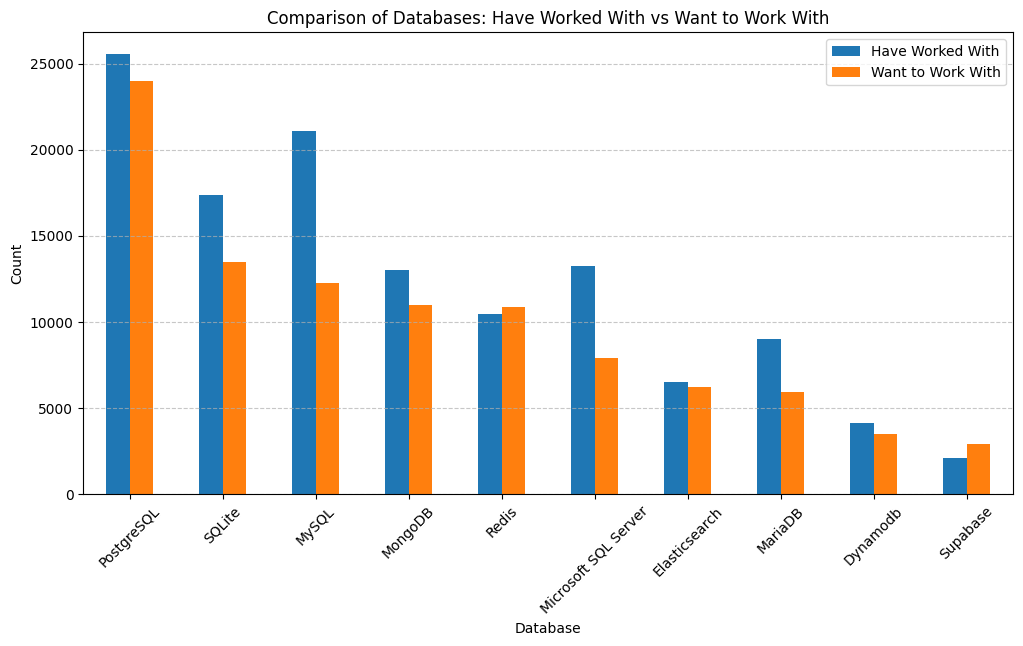

In [ ]:
#*****************************************
#***THIS GRAPH IS BEING USED BY HENRY*****
#*****************************************

df = pd.read_csv('/content/drive/My Drive/2024_survey_results_public.csv')

# Extract the two relevant columns
worked_with = df['DatabaseHaveWorkedWith'].dropna().str.split(';').explode()
want_to_work_with = df['DatabaseWantToWorkWith'].dropna().str.split(';').explode()

# Count occurrences of each database
worked_with_counts = worked_with.value_counts()
want_to_work_with_counts = want_to_work_with.value_counts()

# Combine into a single DataFrame for comparison
comparison_df = pd.DataFrame({
    'Worked With': worked_with_counts,
    'Want to Work With': want_to_work_with_counts
}).fillna(0)

# Convert to integers
comparison_df = comparison_df.astype(int)

# Sort by most wanted databases
comparison_df = comparison_df.sort_values(by='Want to Work With', ascending=False)

# Display the top results
print(comparison_df.head(10))

# Visualization
plt.figure(figsize=(12, 6))
comparison_df.head(10).plot(kind='bar', figsize=(12,6))
plt.title("Comparison of Databases: Have Worked With vs Want to Work With")
plt.xlabel("Database")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(["Have Worked With", "Want to Work With"])
plt.show()

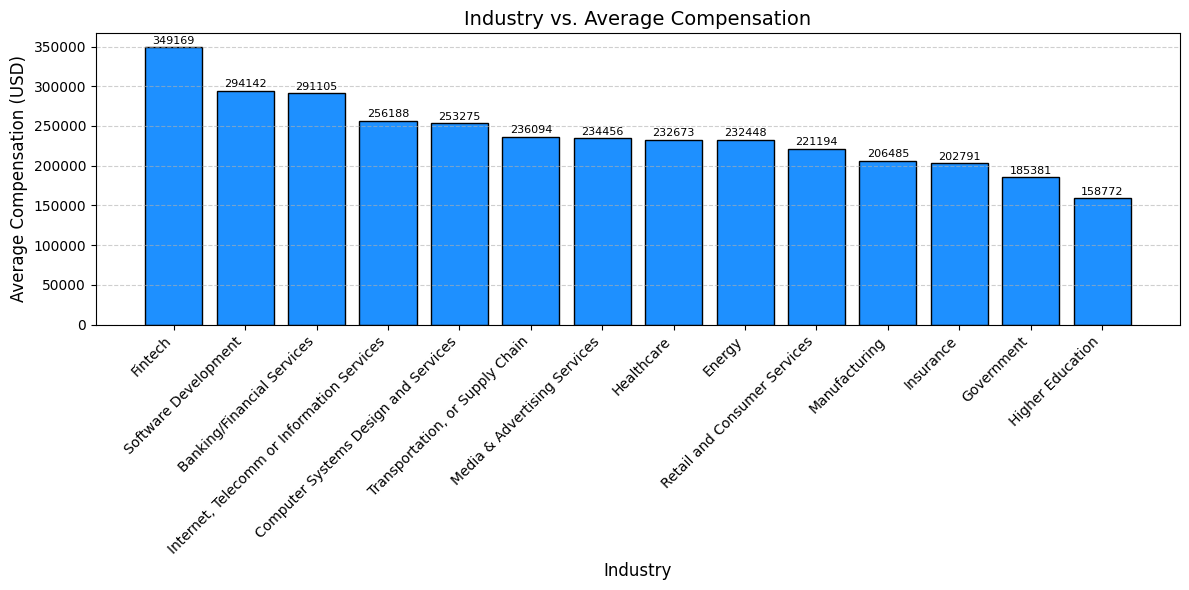

In [ ]:
#*****************************************
#***THIS GRAPH IS BEING USED BY Leighton**
#*****************************************
#***              Plot 1               ***
#*****************************************
# Load the CSV file
df = pd.read_csv("/content/drive/My Drive/2024_survey_results_public.csv", usecols=["Industry", "CompTotal"], low_memory=False)

# Drop missing and unrealistic values
df = df.dropna()
df = df[df["CompTotal"] < 3000000]  # Filter out outlier compensations

# Aggregate compensation by industry
df_grouped = df.groupby("Industry")["CompTotal"].mean().reset_index()

# Define valid industries (removing blanks or misaligned entries)
industries = [
    "Software Development", "Fintech", "Healthcare", "Retail and Consumer Services",
    "Banking/Financial Services", "Media & Advertising Services", "Manufacturing",
    "Transportation, or Supply Chain", "Higher Education", "Insurance", "Energy",
    "Government", "Internet, Telecomm or Information Services", "Computer Systems Design and Services"
]
df_grouped = df_grouped[df_grouped["Industry"].isin(industries)]
df_grouped = df_grouped.set_index("Industry").reindex(industries).fillna(0).reset_index()
df_grouped = df_grouped.sort_values(by="CompTotal", ascending=False)

# Plotting with refined spacing and alignment
plt.figure(figsize=(12, 6))
bar_positions = np.arange(len(df_grouped))  # Precise alignment of bars
bars = plt.bar(bar_positions, df_grouped["CompTotal"], color="dodgerblue", edgecolor="black")

# Enhance x-axis labels
plt.xticks(bar_positions, df_grouped["Industry"], rotation=45, fontsize=10, ha="right")
plt.xlabel("Industry", fontsize=12)
plt.ylabel("Average Compensation (USD)", fontsize=12)
plt.title("Industry vs. Average Compensation", fontsize=14)
plt.grid(axis="y", linestyle="--", alpha=0.6)

# Annotate bars with compensation values
for bar, label in zip(bars, df_grouped["CompTotal"]):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 2000, f"{int(label)}",
             ha="center", va="bottom", fontsize=8)

# Tighten layout for better spacing
plt.tight_layout()
plt.show()


In [ ]:
#*****************************************
#***THIS GRAPH IS BEING USED BY Leighton**
#*****************************************
#***              Plot 2               ***
#*****************************************
%load_ext rpy2.ipython

%%R
library(ggplot2)
library(dplyr)

# Load the CSV file
df <- read.csv("/content/drive/My Drive/2024_survey_results_public.csv", stringsAsFactors=FALSE)

# Select relevant columns and clean the data
df_clean <- df %>%
  select(Industry, JobSat) %>%
  filter(!is.na(Industry) & !is.na(JobSat)) %>% # Remove rows with missing values
  filter(JobSat != "") %>%                      # Exclude empty values
  mutate(JobSat = as.numeric(JobSat))          # Ensure JobSat is numeric

# Define a color palette for industries
industry_colors <- c(
  "Software Development" = "#1f77b4",
  "Computer Systems Design and Services" = "#ff7f0e",
  "Internet, Telecomm or Information Services" = "#2ca02c",
  "Fintech" = "#d62728",
  "Energy" = "#9467bd",
  "Government" = "#8c564b",
  "Banking/Financial Services" = "#e377c2",
  "Healthcare" = "#7f7f7f",
  "Retail and Consumer Services" = "#bcbd22",
  "Higher Education" = "#17becf",
  "Media & Advertising Services" = "#aec7e8",
  "Insurance" = "#98df8a",
  "Manufacturing" = "#ff9896",
  "Transportation, or Supply Chain" = "#c5b0d5",
  "Other" = "#c49c94"
)

# Plot the box plot
ggplot(df_clean, aes(x=Industry, y=JobSat, fill=Industry)) +
  geom_boxplot(outlier.shape = NA, alpha=0.8) + # Hide outliers for clearer view
  scale_fill_manual(values=industry_colors) +  # Apply custom colors
  labs(
    title = "Industry vs. Job Satisfaction",
    x = "Industry",
    y = "Job Satisfaction Score"
  ) +
  theme_minimal() + # Apply a clean theme
  theme(
    axis.text.x = element_text(angle=45, hjust=1, size=10), # Rotate and size x-axis labels
    axis.text.y = element_text(size=10),                   # Adjust y-axis text size
    legend.position = "none",                              # Hide legend for simplicity
    plot.title = element_text(hjust=0.5, size=14),         # Center and size the title
    plot.margin = unit(c(1, 1, 1, 2), "cm")                # Increase left margin (last value is left margin)
  ) +
  geom_jitter(
    aes(color=Industry), shape=16, size=0.5, width=0.2, alpha=0.6
  ) + # Add jittered points for individual data visibility
  guides(color=FALSE)

SyntaxError: invalid syntax (<ipython-input-17-b8d7db7bc2fb>, line 16)

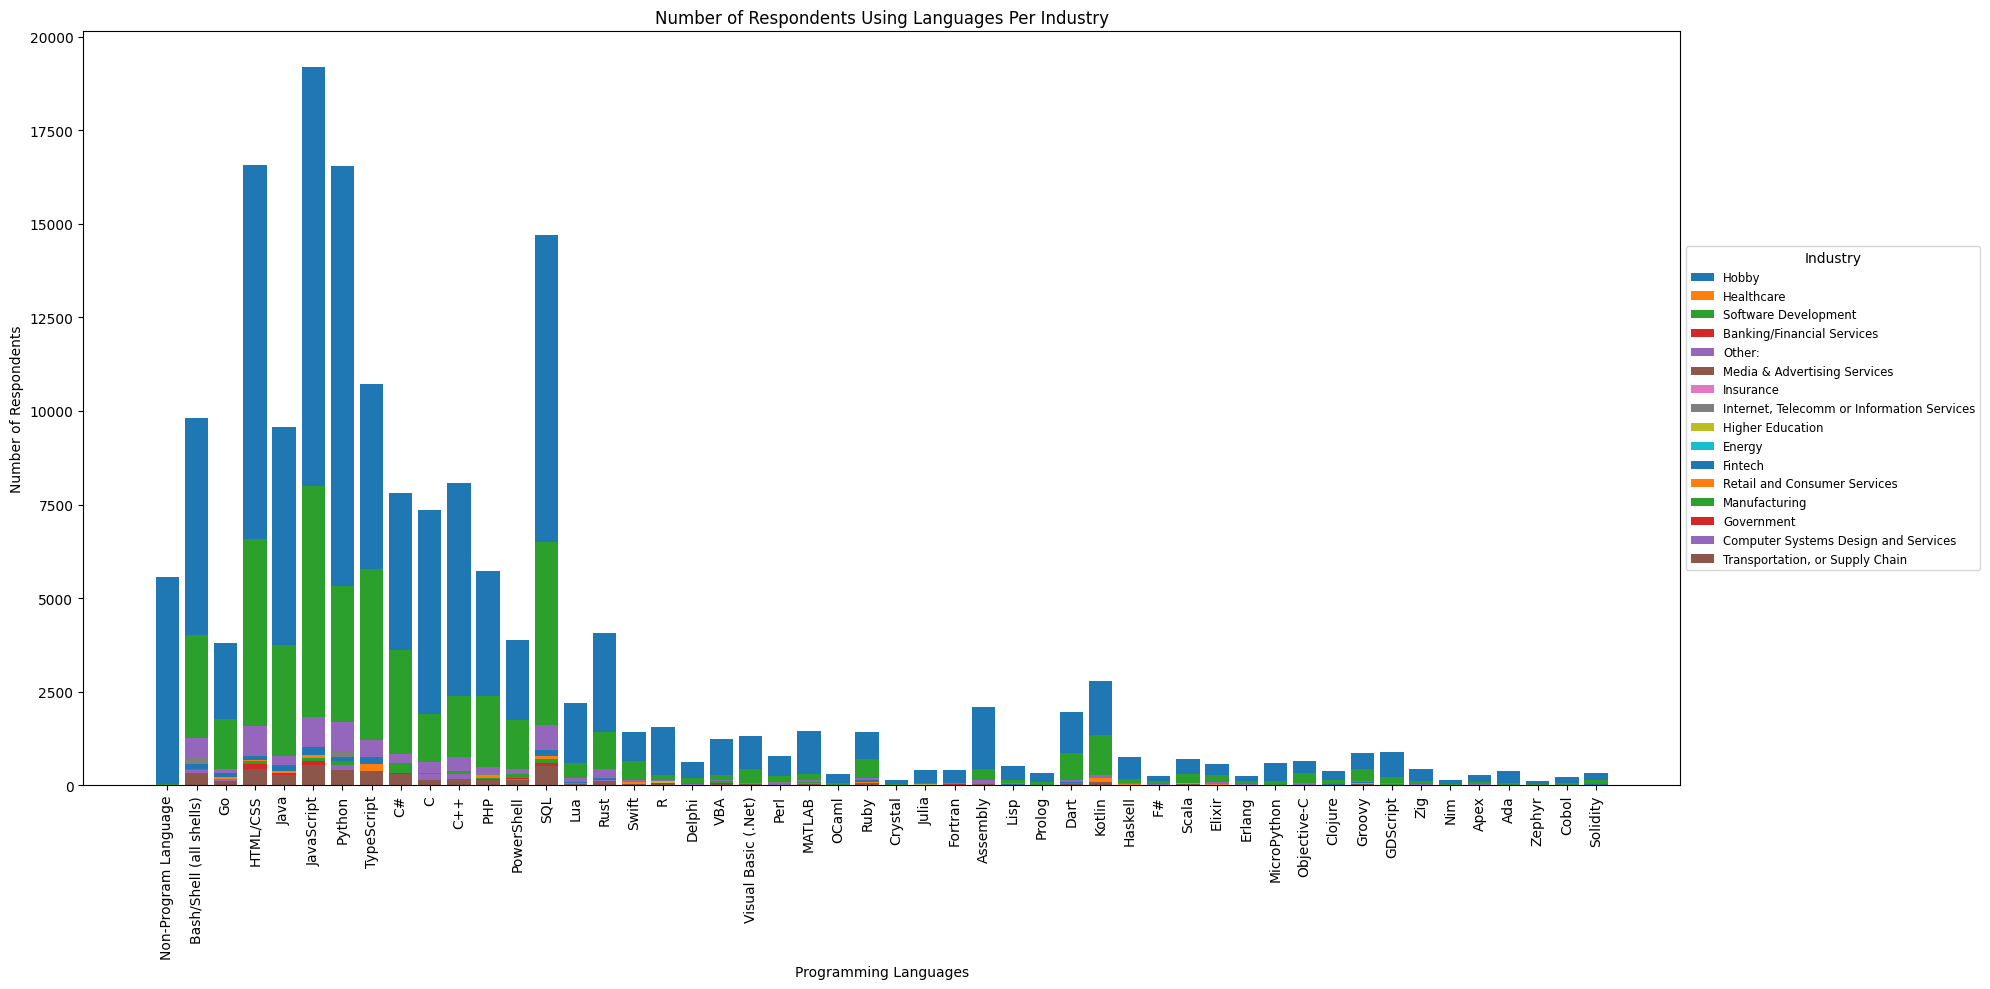

In [ ]:
#*****************************************
#***THIS GRAPH IS BEING USED BY Leighton**
#*****************************************
#***              Plot 3               ***
#*****************************************
# Load the CSV file
df = pd.read_csv("/content/drive/My Drive/2024_survey_results_public.csv",usecols=["Industry", "LanguageHaveWorkedWith"],low_memory=False)

# Replace NaN values in relevant columns
df['LanguageHaveWorkedWith'] = df['LanguageHaveWorkedWith'].fillna('Non-Program Language')
df['Industry'] = df['Industry'].fillna('Hobby')

# Parse programming languages and group by industry
industry_language_counts = {}

for _, row in df.iterrows():
    industry = row['Industry']
    languages = str(row['LanguageHaveWorkedWith']).split(';')  # Ensure valid parsing

    if industry not in industry_language_counts:
        industry_language_counts[industry] = Counter()

    industry_language_counts[industry].update(languages)

# Validate industry_language_counts to ensure it contains Counter objects
for industry, counts in industry_language_counts.items():
    if not isinstance(counts, Counter):
        raise ValueError(f"Unexpected value in industry_language_counts: {counts}")

# Generate the plot
plt.figure(figsize=(20, 10))

for industry, counts in industry_language_counts.items():
    languages = list(counts.keys())
    occurrences = list(counts.values())
    plt.bar(languages, occurrences, label=industry)

plt.xticks(rotation=90)
plt.xlabel('Programming Languages')
plt.ylabel('Number of Respondents')
plt.title('Number of Respondents Using Languages Per Industry')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), title='Industry', fontsize='small')
plt.tight_layout()

# Save the plot
plt.savefig('language_usage_per_industry_updated.png', dpi=300)
plt.show()

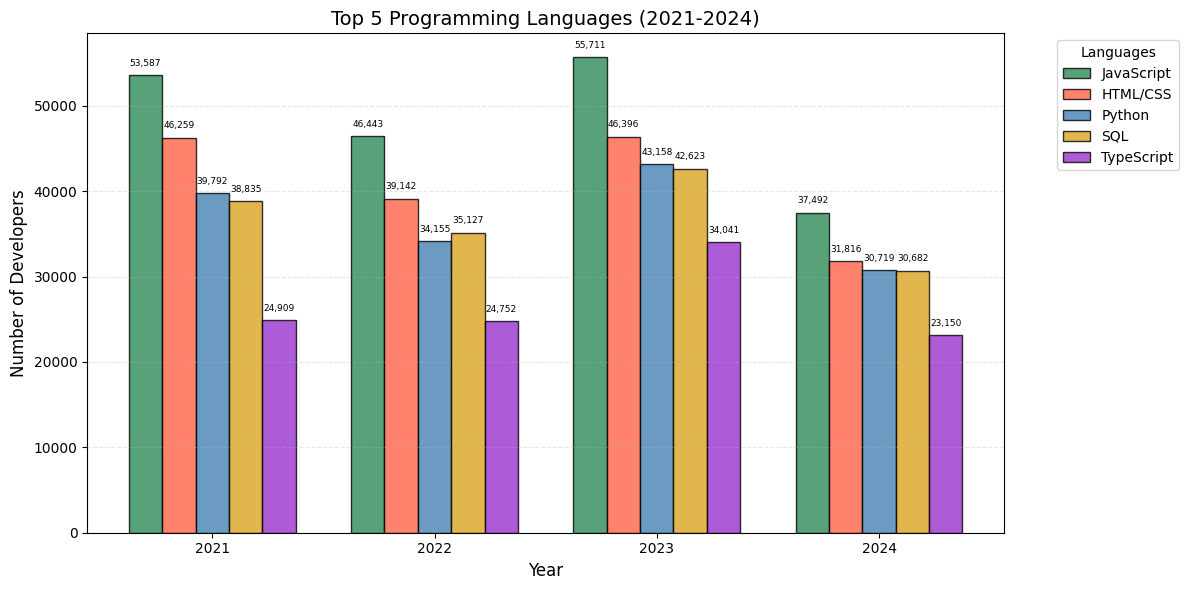

This graph is being used by Yulia


In [ ]:
#*************************************************
#***THIS GRAPH IS BEING USED BY YULIA FREEMAN*****
#*************************************************

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load the combined CSV
df = pd.read_csv(r"/content/drive/MyDrive/survey_results_combined.csv", low_memory=False)

# Process languages for each year
language_trends = (df.groupby('Year')['LanguageHaveWorkedWith']
                  .apply(lambda x: x.str.split(';', expand=True).stack().value_counts())
                  .reset_index())

# Rename columns explicitly (assuming the count is the last column)
language_trends.columns = ['Year', 'Language', 'Count']

# Get top 5 languages overall
top_languages_overall = (df['LanguageHaveWorkedWith']
                        .str.split(';', expand=True)
                        .stack()
                        .value_counts()
                        .head(5)
                        .index)

# Filter trends to top languages
language_trends = language_trends[language_trends['Language'].isin(top_languages_overall)]

# Pivot the data for grouped bar chart
pivot_df = language_trends.pivot(index='Year', columns='Language', values='Count').fillna(0)

# Define colors
bright_colors = [
    '#2E8B57', '#FF6347', '#4682B4', '#DAA520', '#9932CC',
    '#FF4500', '#20B2AA', '#FFD700', '#6A5ACD', '#FF69B4'
][:len(top_languages_overall)]

# Create figure
plt.figure(figsize=(12, 6))

# Parameters for grouped bars
bar_width = 0.15
years = pivot_df.index
n_languages = len(top_languages_overall)
index = np.arange(len(years))

# Plot bars for each language with black outlines
for i, (language, color) in enumerate(zip(top_languages_overall, bright_colors)):
    plt.bar(index + i * bar_width, pivot_df[language],
            bar_width, label=language, color=color, alpha=0.8,
            edgecolor='black', linewidth=1)  # Added black outline for clarity

# Customize
plt.title('Top 5 Programming Languages (2021-2024)', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Number of Developers', fontsize=12)
plt.xticks(index + bar_width * (n_languages - 1) / 2, years)
plt.legend(title='Languages', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.3)

# Add data labels
for i, language in enumerate(top_languages_overall):
    for j, year in enumerate(years):
        count = pivot_df.loc[year, language]
        if count > 0:
            plt.text(index[j] + i * bar_width, count + (pivot_df.values.max() * 0.02),
                     f'{int(count):,}',
                     ha='center', fontsize=6.5)

# Adjust layout
plt.tight_layout()
plt.show()
print ("This graph is being used by Yulia")

In [ ]:
#******************************************************
# Code is being used by Yulia Freeman for final project
#******************************************************
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from scipy.stats import gaussian_kde

# Load the CSV
df = pd.read_csv(r"/content/drive/MyDrive/survey_results_combined.csv", low_memory=False)

# Define the years to analyze
years = [2021, 2022, 2023, 2024]

# Get top 5 frameworks overall
top_frameworks_overall = (df['WebframeHaveWorkedWith']
                          .str.split(';', expand=True)
                          .stack()
                          .value_counts()
                          .head(5)
                          .index)

# Initialize a DataFrame to store counts
data = {framework: [0] * len(years) for framework in top_frameworks_overall}
df_counts = pd.DataFrame(data, index=years)

# Count framework appearances per year
for year in years:
    df_year = df[df['Year'] == year]
    framework_counts = (df_year['WebframeHaveWorkedWith']
                        .str.split(';', expand=True)
                        .stack()
                        .value_counts())
    for framework in top_frameworks_overall:
        if framework in framework_counts:
            df_counts.loc[year, framework] = framework_counts[framework]

# Prepare ridgeline data
x = np.linspace(2021, 2024, 300)
offset = 1.5
ridge_data = []

# Use RGBA for colors
colors = [
    "rgba(31, 119, 180, 0.5)",
    "rgba(255, 127, 14, 0.5)",
    "rgba(44, 160, 44, 0.5)",
    "rgba(214, 39, 40, 0.5)",
    "rgba(148, 103, 189, 0.5)"
]

line_colors = [  # Same colors without alpha
    "rgb(31, 119, 180)",
    "rgb(255, 127, 14)",
    "rgb(44, 160, 44)",
    "rgb(214, 39, 40)",
    "rgb(148, 103, 189)"
]

fig = go.Figure()

for i, framework in enumerate(top_frameworks_overall):
    y_counts = df_counts[framework].values
    y_years = df_counts.index.values

    interp_counts = np.interp(x, y_years, y_counts)
    kde = gaussian_kde(y_years, weights=y_counts, bw_method=0.5)
    density = kde(x)
    density_scaled = density / density.max() * max(y_counts) * 0.3
    ridge_y = density_scaled + i * offset

    # Ridgeline trace
    fig.add_trace(go.Scatter(
        x=x,
        y=ridge_y,
        mode='lines',
        fill='tozeroy',
        name=framework,
        line=dict(color=line_colors[i], width=1.5),
        fillcolor=colors[i],
        hovertemplate=f"{framework}<br>Year: %{{x:.2f}}<br>Scaled Density: %{{y:.2f}}<extra></extra>"
    ))

    # Add label annotation
    label_x = 2024.2
    label_y = max(ridge_y)

    fig.add_annotation(
        x=label_x,
        y=label_y,
        text=framework,
        showarrow=False,
        font=dict(size=13, color=line_colors[i]),
        xanchor='left'
    )

    # Dashed line from ridge to label
    fig.add_shape(
        type="line",
        x0=2024,
        y0=label_y,
        x1=label_x - 0.02,
        y1=label_y,
        line=dict(color=line_colors[i], width=1, dash='dot')
    )

# Layout
fig.update_layout(
    title="Ridgeline Plot of Top 5 Frameworks (2021–2024)",
    xaxis_title="Year",
    yaxis_title="",
    showlegend=False,
    width=900,
    height=800,
    margin=dict(l=80, r=160, t=80, b=80),
    xaxis=dict(
        tickmode='array',
        tickvals=years,
        ticktext=[str(y) for y in years],
        showline=False,
        zeroline=False
    ),
    yaxis=dict(
        showticklabels=False,
        showgrid=False,
        zeroline=False
    ),
    plot_bgcolor='white',
    paper_bgcolor='white',
    hovermode='x unified'
)

fig.show()
print ("This graph is being used by Yulia")

This graph is being used by Yulia


In [ ]:
#******************************************************
# Code is being used by Yulia Freeman for final project
#******************************************************
import pandas as pd
import numpy as np
import plotly.graph_objects as go

# Load the CSV
df = pd.read_csv(r"/content/drive/MyDrive/survey_results_combined.csv", low_memory=False)

# Get top 5 languages
top_languages_overall = (df['LanguageHaveWorkedWith']
                        .str.split(';', expand=True)
                        .stack()
                        .value_counts()
                        .head(5)
                        .index)

# Select tech column
tech_column = 'WebframeHaveWorkedWith'

# Get top 5 frameworks
top_techs = (df[tech_column]
             .str.split(';', expand=True)
             .stack()
             .value_counts()
             .head(5)
             .index)

# Create a list to collect all links
links = []

# Count co-occurrences
for _, row in df.iterrows():
    langs = set(str(row['LanguageHaveWorkedWith']).split(';')) & set(top_languages_overall)
    techs = set(str(row[tech_column]).split(';')) & set(top_techs)

    for lang in langs:
        for tech in techs:
            links.append((lang, tech))

# Convert to DataFrame and count
link_df = pd.DataFrame(links, columns=['Language', 'Framework'])
link_counts = link_df.value_counts().reset_index(name='count')

# Create unique list of nodes
all_nodes = list(top_languages_overall) + list(top_techs)
node_indices = {name: i for i, name in enumerate(all_nodes)}

# Build Sankey node and link components
source = [node_indices[lang] for lang in link_counts['Language']]
target = [node_indices[fw] for fw in link_counts['Framework']]
value = link_counts['count']

# Define node colors
node_colors = [
    "#2E8B57", "#FF6347", "#4682B4", "#DAA520", "#9932CC",  # Languages
    "#FF4500", "#20B2AA", "#FFD700", "#6A5ACD", "#FF69B4"   # Frameworks
]

# Map link colors to source node (language) colors
link_colors = [node_colors[src] for src in source]

# Sankey Diagram
fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=20,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=all_nodes,
        color=node_colors
    ),
    link=dict(
        source=source,
        target=target,
        value=value,
        color=link_colors
    )
)])

fig.update_layout(
    title_text="Parallel Sets: Top 5 Programming Languages and Top 5 Frameworks",
    font_size=12,
    width=1000  # Set narrower width
)
fig.show()
print ("This graph is being used by Yulia")

This graph is being used by Yulia
